In [13]:
import glob
import numpy as np
import pandas as pd 
from collections import defaultdict
from math import isclose
from matplotlib import pyplot as plt

In [14]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angleof(v1, v2=np.array([1,0])):
    return np.degrees(np.arctan2(v1[0], v1[1]))
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))


In [32]:
%%prun -s cumulative -q -l 10 -T prun0


 
*** Profile printout saved to text file 'prun0'. 


In [33]:
runs = glob.glob('/home/gabrihacker/TNSM2022/results_rebuttal/napoli/*/*/*/*/*/*/')

max_angles = []
mean_angles = []
min_distances = []
for r in runs:
    params = r.split('/')
    sa, rf, k, ratio, dens = params[7:12]
    bp = '/'.join(params[:8])

    invmat = np.load(f'{bp}/inverse_translation_matrix.npy')
    viewsheds = np.load(f'{r}/viewsheds.npy')
    nodes = pd.read_csv(f'{r}/index.csv', 
                        sep=' ', 
                        header=0, 
                        names=['x', 'y', 'z', 'x_3003', 'y_3003', 'b', 'p_i']
                        ).set_index('p_i')
    links = np.argwhere(viewsheds) #get ones from the viewshed
    nodes_dict = {}
    for n in nodes.index:
        pn = nodes.loc[n]
        nodes_dict[n] = np.array([pn.x, pn.y])

    #create a dict with a list of bs that sees a point
    adjdict = defaultdict(list)
    for l in links:
        ant = l[1]
        p = l[0]
        if ant in nodes.index:
            adjdict[p].append(nodes_dict[ant])

    for p in adjdict.keys():
        bs_loc = invmat[p]
        dists = []
        angles = []
        vectors = []
        for loc in adjdict[p]:
            vector = loc-bs_loc
            vectors.append(vector)
            dists.append(np.abs(vector))
            angles.append(angleof(vector))     
        angles.sort()      
        angles.append(angles[0])  ##Trick to create a ring
        angles = np.array(angles) #convert to n[0], vector[1]umpy
        min_distances.append(np.array(dists).min(axis=0))
        diffs = (angles[1:] - angles[:-1]) % 360  #modulo 360 to get positive  angles
        assert(isclose(sum(diffs),360) or isclose(sum(diffs),0))
        max_angles.append(diffs.max())
        mean_angles.append(diffs.mean())
        

 
*** Profile printout saved to text file 'prun0'. 


(array([1.14503e+05, 0.00000e+00, 1.21000e+02, 9.50000e+01, 7.75000e+02,
        1.66060e+04, 8.85800e+03, 1.27450e+04, 1.40820e+04, 1.61570e+04]),
 array([  0.        ,  35.99905393,  71.99810785, 107.99716178,
        143.99621571, 179.99526963, 215.99432356, 251.99337749,
        287.99243141, 323.99148534, 359.99053927]),
 <a list of 10 Patch objects>)

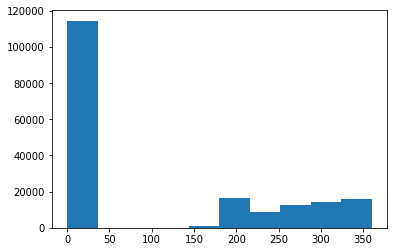

In [35]:
ma_data = np.ma.masked_equal(max_angles,0)
plt.hist(max_angles)

KeyboardInterrupt: 

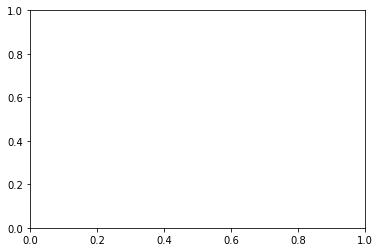

In [38]:
plt.hist(min_distances)